In [2]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations

## Matching Approach Simulation

### Setup 1

Modify the balancing weight function to make the optimized weight a binary output of {0,1}

In [3]:
np.random.seed(123)

n_sims = 1 # number of repetitions
N = 100 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

# assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments

# generate true main effects
def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)


def solve_matching_additive(X, Z, alpha = 1.0):
    N, D = X.shape
    K = Z.shape[1]
    
    Aplus = np.where(Z>0, 1.0, 0.0)
    Aminus= 1.0 - Aplus

    # sumX[d] = sum of X[:, d] over *all* individuals
    # The original code tries to match these exactly for both plus and minus

    # Build the model
    model = gp.Model("AdditiveBalance_binary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")

    # Objective: maximize the number of selected units
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)), GRB.MAXIMIZE)

    # Slack variables for each (k,d) pair
    delta_pos = {}
    delta_neg = {}
    for k_ in range(K):
        for d_ in range(D):
            delta_pos[(k_, d_)] = model.addVar(lb=0.0, name=f"deltaPos_k{k_}_d{d_}")
            delta_neg[(k_, d_)] = model.addVar(lb=0.0, name=f"deltaNeg_k{k_}_d{d_}")

    # Build constraints
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i] * Aplus[i,k_]  * X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i] * Aminus[i,k_] * X[i,d_] for i in range(N))
            # lhs_plus - lhs_minus <= delta_pos
            model.addConstr(lhs_plus - lhs_minus <= delta_pos[(k_, d_)])
            # lhs_minus - lhs_plus <= delta_neg
            model.addConstr(lhs_minus - lhs_plus <= delta_neg[(k_, d_)])

        # Optionally, also match group sizes with slack if you like:
        #   plus_count - minus_count <= deltaPos_count
        #   minus_count - plus_count <= deltaNeg_count
        # We'll skip that here, but it's the same pattern.

    # Build objective: alpha * sum(w_i) - sum of slack
    sum_w = gp.quicksum(w_vars[i] for i in range(N))
    sum_slack = gp.quicksum(delta_pos[(k_, d_)] + delta_neg[(k_, d_)]
                            for k_ in range(K) for d_ in range(D))
    model.setObjective(alpha*sum_w - sum_slack, GRB.MAXIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("No optimal solution or infeasible.")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_matching_heterogeneous(X, Z, alpha=1.0):
    N, D = X.shape
    K = Z.shape[1]
    Aplus  = (Z>0).astype(float)
    Aminus = 1.0 - Aplus

    model = gp.Model("HeteroBinary")
    model.setParam('OutputFlag', 0)

    # w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")

    # We'll maximize the number of selected units
    model.setObjective(gp.quicksum(w_vars[i] for i in range(N)), GRB.MAXIMIZE)
    # Build a small basis: intercept + raw covariates
    basis_vals = []
    col_count = 0
    # Intercept
    basis_vals.append(np.ones(N))
    col_count += 1
    # Each X[:, d]
    for d_ in range(D):
        basis_vals.append(X[:, d_])
        col_count += 1
    # (Add partial interactions if you like.)

    # Slack variables: one pair (deltaPos, deltaNeg) per factor k & basis column b
    delta_pos = {}
    delta_neg = {}

    for k_ in range(K):
        for b_ in range(col_count):
            delta_pos[(k_, b_)] = model.addVar(lb=0.0, name=f"deltaPos_k{k_}_b{b_}")
            delta_neg[(k_, b_)] = model.addVar(lb=0.0, name=f"deltaNeg_k{k_}_b{b_}")

    # Constraints
    for k_ in range(K):
        for b_ in range(col_count):
            lhs_plus  = gp.quicksum(w_vars[i] * Aplus[i,k_]  * basis_vals[b_][i] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i] * Aminus[i,k_] * basis_vals[b_][i] for i in range(N))
            model.addConstr(lhs_plus - lhs_minus <= delta_pos[(k_, b_)])
            model.addConstr(lhs_minus - lhs_plus <= delta_neg[(k_, b_)])

    # Objective
    sum_w = gp.quicksum(w_vars[i] for i in range(N))
    sum_slack = gp.quicksum(delta_pos[(k_, b_)] + delta_neg[(k_, b_)]
                            for k_ in range(K) for b_ in range(col_count))
    model.setObjective(alpha * sum_w - sum_slack, GRB.MAXIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("No optimal solution or infeasible.")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

    
#  Do an naive difference in means for each factor to estimate the factorial effect
def estimate_main_effects_matched(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau_est_matched = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est_matched[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est_matched[k_+1] = mean_plus - mean_minus
    return tau_est_matched


# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance_matched(X, Z, selection):
    sd_X = np.std(X, axis=0, ddof=1)
    smd = np.zeros((K, D))
    for k in range(K):
        plus_mask = (Z[:, k] == +1) & (selection == 1)
        minus_mask = (Z[:, k] == -1) & (selection == 1)
        if np.sum(plus_mask) > 0:
            mean_plus = np.mean(X[plus_mask], axis=0)
        else:
            mean_plus = np.full(X.shape[1], np.nan)
        if np.sum(minus_mask) > 0:
            mean_minus = np.mean(X[minus_mask], axis=0)
        else:
            mean_minus = np.full(X.shape[1], np.nan)
        diff = mean_plus - mean_minus
        smd[k, :] = diff / (sd_X + 1e-15)
    return smd


# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_simulation_matching(n_sims=10, N=1000, model_type="additive", alpha=1.0):

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "heterogeneous":
        Yfn = Y_model_het
    elif model_type == "misspecified":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")

    true_tau = true_main_effects(Yfn)
    matched_taus_add = []
    matched_taus_het = []
    smds_add = []
    smds_het = []
    ess_add = []
    ess_het = []

    for sim in range(n_sims):
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_   = generate_treatments(Xraw)
        Y_   = simulate_Y(Xraw, Z_, model=model_type)

        # Solve for 0/1 match vectors
        matchA = solve_matching_additive(Xraw, Z_, alpha=alpha)
        matchH = solve_matching_heterogeneous(Xraw, Z_, alpha=alpha)
        print(matchA)
        print(matchH)

        if matchA is None:
            matched_taus_add.append([np.nan, np.nan, np.nan])
            smds_add.append(np.full((K, D), np.nan))
        else:
            tA = estimate_main_effects_matched(Y_, Z_, matchA)
            matched_taus_add.append([tA[1], tA[2], tA[3]])
            ess_add = np.sum(matchA)
            smd_add = get_covariate_balance_matched(Xraw, Z_, matchA)
            smds_add.append(smd_add)

        if matchH is None:
            matched_taus_het.append([np.nan, np.nan, np.nan])
            smds_het.append(np.full((K, D), np.nan))
        else:
            tH = estimate_main_effects_matched(Y_, Z_, matchH)
            matched_taus_het.append([tH[1], tH[2], tH[3]])
            ess_het = np.sum(matchH)
            smd_het = get_covariate_balance_matched(Xraw, Z_, matchH)
            smds_het.append(smd_het)

    # Convert to arrays
    matched_taus_add = np.array(matched_taus_add)
    matched_taus_het = np.array(matched_taus_het)
    smds_add = np.array(smds_add)  
    smds_het = np.array(smds_het) 
    ess_add = np.array(ess_add)
    ess_het = np.array(ess_het)

    def rmse(vals, truth):
        return np.sqrt(np.nanmean((vals - truth)**2, axis=0))

    # shape (n_sims, 3) 
    add_rmse = rmse(matched_taus_add, [true_tau[1], true_tau[2], true_tau[3]])
    het_rmse = rmse(matched_taus_het, [true_tau[1], true_tau[2], true_tau[3]])

    mean_smd_add = np.nanmean(smds_add, axis=0)  
    mean_smd_het = np.nanmean(smds_het, axis=0)  

    return {
        "true_tau": true_tau,
        "rmse_matched_additive": add_rmse,
        "rmse_matched_hetero":   het_rmse,
        'mean_smd_add': mean_smd_add,
        'mean_smd_het': mean_smd_het,
        'ess_add': ess_add,
        'ess_het': ess_het
    }


In [ ]:
if __name__=="__main__":
    simulation_results_dict = {}
    for mtype in ["additive","heterogeneous","misspecified"]:
        res = run_simulation_matching(n_sims=10, N=1000, model_type=mtype, alpha=3.5)
        simulation_results_dict[mtype] = res
        # Print results
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (weighting add.):",     res['rmse_matched_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_matched_hetero'])
        print("\nMean SMD (Additive Weights):")
        print_array_5sig(res['mean_smd_add'])
        print("\nMean SMD (Hetero Weights):")
        print_array_5sig(res['mean_smd_het'])
        print("Effective sample size(additive):", res['ess_add'])
        print("Effective sample size(hetero):", res['ess_het'])


Set parameter Username
Set parameter LicenseID to value 2622621
Academic license - for non-commercial use only - expires 2026-02-16
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1

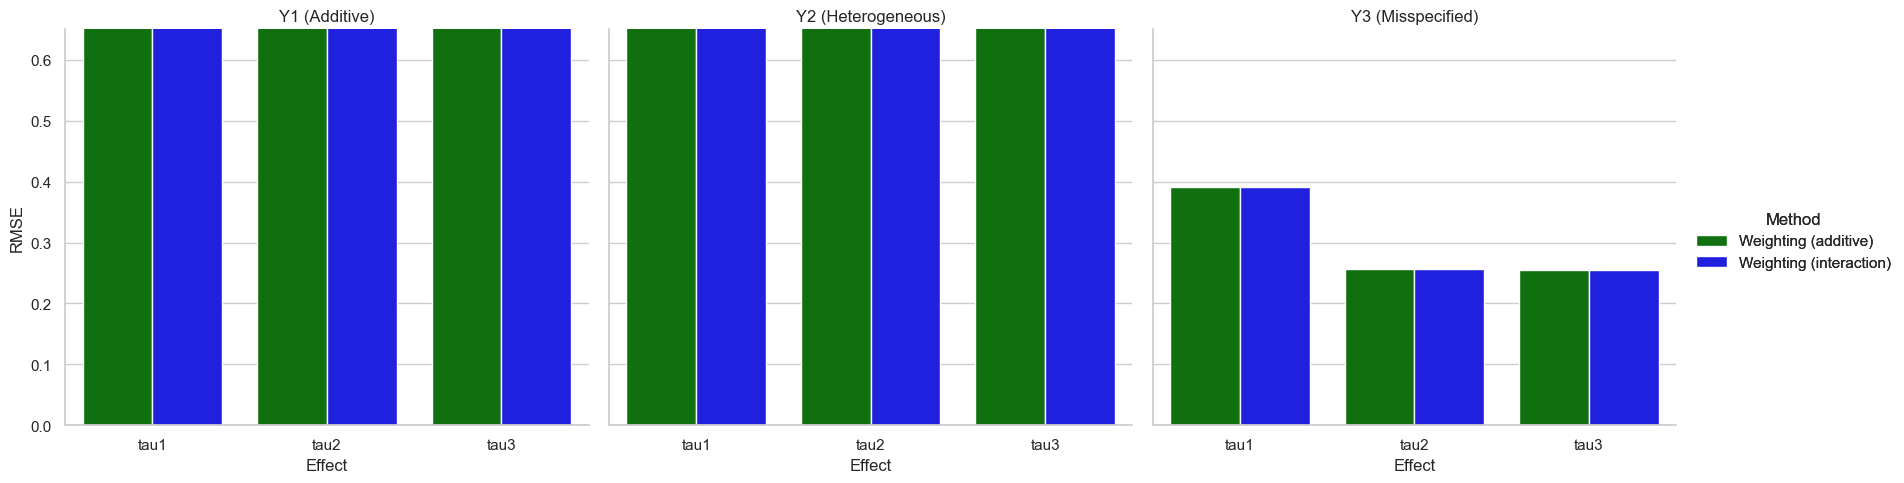

In [ ]:
def plot_rmse_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    methods = ["rmse_matched_additive", "rmse_matched_hetero"]
    method_names = ["Weighting (additive)", "Weighting (interaction)"]
    models = {"additive": "Y1 (Additive)", "heterogeneous": "Y2 (Heterogeneous)", "misspecified": "Y3 (Misspecified)"}
    
    data = []
    for model_type, results in results_dict.items():
        for method, method_name in zip(methods, method_names):
            for i, effect in enumerate(effects):
                data.append([models[model_type], effect, results[method][i], method_name])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )

    g.set_axis_labels("Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    g.set(ylim=(0, 0.65))
    
    plt.show()

results_dict = simulation_results_dict

plot_rmse_comparison_approx(results_dict)

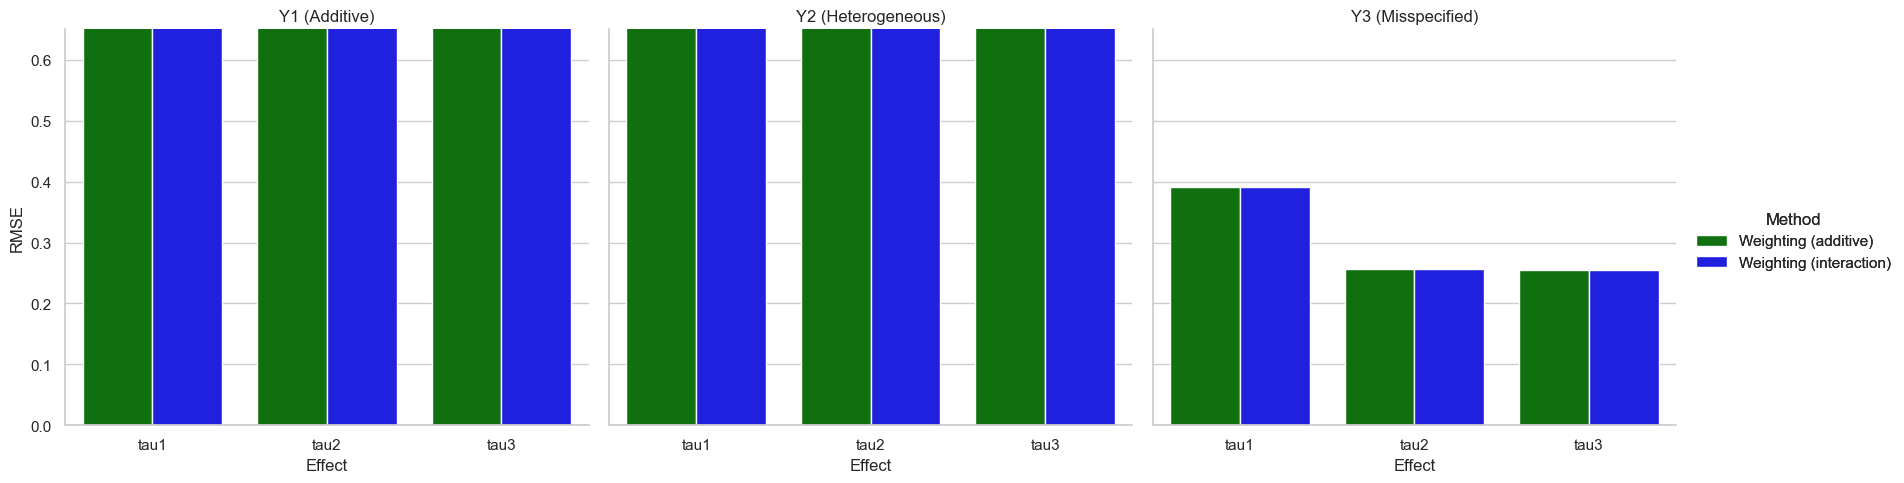

In [ ]:
def plot_SMDs_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    methods = ["mean_smd_add", "mean_smd_het"]
    method_names = ["Weighting (additive)", "Weighting (interaction)"]
    models = {"additive": "Y1 (Additive)", "heterogeneous": "Y2 (Heterogeneous)", "misspecified": "Y3 (Misspecified)"}
    
    data = []
    for model_type, results in results_dict.items():
        for method, method_name in zip(methods, method_names):
            for i, effect in enumerate(effects):
                data.append([models[model_type], effect, results[method][i], method_name])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "SMDs", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="SMDs",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['green', 'blue'],
        height=5,
        aspect=1
    )

    g.set_axis_labels("Effect", "SMDs")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    g.set(ylim=(0, 0.65))
    
    plt.show()

results_dict = simulation_results_dict

plot_rmse_comparison_approx(results_dict)